In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import hist.dask as dhist
import dask
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import pandas as pd
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc

/tmp/ipykernel_2187726/137746131.py:8: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  import coffea.nanoevents.methods.vector as vector


In [2]:
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")
warnings.filterwarnings("ignore", "The necessary")
warnings.filterwarnings("ignore",  module="coffea.*")

In [17]:
subcut = False
use_hgg = True

In [18]:
if (subcut == True) and (use_hgg == True):
    #Read in files with subjet cut 
    hgg = ak.from_parquet('/scratch365/cmoore24/training/data/subcut/hgg.parquet')
    background = ak.from_parquet('/scratch365/cmoore24/training/data/subcut/qcd.parquet')
    with open('models_and_scalers/hgg_subcut_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    model = 'models_and_scalers/hgg_subcut_traced_model.pt'
    print('Hgg and QCD data with subjets >= 3')

elif (subcut == True) and (use_hgg == False):
    #Read in files with subjet cut 
    hbb = ak.from_parquet('/scratch365/cmoore24/training/data/subcut/hbb.parquet')
    background = ak.from_parquet('/scratch365/cmoore24/training/data/subcut/qcd.parquet')
    with open('models_and_scalers/hbb_subcut_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    model = 'models_and_scalers/hbb_subcut_traced_model.pt'
    print('Hbb and QCD data with subjets >= 3')
    
elif (subcut == False) and (use_hgg == True):
    #Read in files without subcut
    hgg = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/hgg.parquet')
    background = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/qcd.parquet')
    with open('models_and_scalers/hgg_nosubcut_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    model = 'models_and_scalers/hgg_nosubcut_traced_model.pt'
    print('Hgg and QCD with no subjet number requirement')

elif (subcut == False) and (use_hgg == False):
    #Read in files without subcut
    hbb = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/hbb.parquet')
    background = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/qcd.parquet')
    with open('models_and_scalers/hbb_nosubcut_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    model = 'models_and_scalers/hbb_nosubcut_traced_model.pt'
    print('Hbb and QCD with no subjet number requirement')

Hgg and QCD with no subjet number requirement


In [19]:
if use_hgg == True:
    pick = hgg
    title = 'hgg'
    print('pick is hgg')
else:
    pick = hbb
    title = 'hbb'
    print('pick is hbb')

pick = pick[pick['FatJets.msoftdrop'] < 200]
pick = pick[pick['FatJets.msoftdrop'] > 40]
pick = pick[pick['FatJets.pt'] < 600]
pick = pick[pick['FatJets.pt'] > 450]
pick['FatJets.mratio'] = pick['FatJets.mass']/pick['FatJets.msoftdrop']

background = background[background['FatJets.msoftdrop'] < 200]
background = background[background['FatJets.msoftdrop'] > 40]
background = background[background['FatJets.pt'] < 600]
background = background[background['FatJets.pt'] > 450]
background['FatJets.mratio'] = background['FatJets.mass']/background['FatJets.msoftdrop']

pick is hgg


In [20]:
zqq = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/zqq.parquet')
zqq = zqq[zqq['FatJets.msoftdrop'] < 200]
zqq = zqq[zqq['FatJets.msoftdrop'] > 40]
zqq = zqq[zqq['FatJets.pt'] < 600]
zqq = zqq[zqq['FatJets.pt'] > 450]

wqq = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/wqq.parquet')
wqq = wqq[wqq['FatJets.msoftdrop'] < 200]
wqq = wqq[wqq['FatJets.msoftdrop'] > 40]
wqq = wqq[wqq['FatJets.pt'] < 600]
wqq = wqq[wqq['FatJets.pt'] > 450]

ttboosted = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/ttboosted.parquet')
ttboosted = ttboosted[ttboosted['FatJets.msoftdrop'] < 200]
ttboosted = ttboosted[ttboosted['FatJets.msoftdrop'] > 40]
ttboosted = ttboosted[ttboosted['FatJets.pt'] < 600]
ttboosted = ttboosted[ttboosted['FatJets.pt'] > 450]

singletop = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/singletop.parquet')
singletop = singletop[singletop['FatJets.msoftdrop'] < 200]
singletop = singletop[singletop['FatJets.msoftdrop'] > 40]
singletop = singletop[singletop['FatJets.pt'] < 600]
singletop = singletop[singletop['FatJets.pt'] > 450]

ww = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/ww.parquet')
ww = ww[ww['FatJets.msoftdrop'] < 200]
ww = ww[ww['FatJets.msoftdrop'] > 40]
ww = ww[ww['FatJets.pt'] < 600]
ww = ww[ww['FatJets.pt'] > 450]

wz = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/wz.parquet')
wz = wz[wz['FatJets.msoftdrop'] < 200]
wz = wz[wz['FatJets.msoftdrop'] > 40]
wz = wz[wz['FatJets.pt'] < 600]
wz = wz[wz['FatJets.pt'] > 450]

zz = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/zz.parquet')
zz = zz[zz['FatJets.msoftdrop'] < 200]
zz = zz[zz['FatJets.msoftdrop'] > 40]
zz = zz[zz['FatJets.pt'] < 600]
zz = zz[zz['FatJets.pt'] > 450]

In [21]:
full_background = ak.concatenate([background, zqq, wqq, ttboosted, singletop, ww, wz, zz])

In [22]:
class ParticleNetExample1(torch_wrapper):
    def prepare_awkward(self, events, scaler):
        fatjets = events

        imap = {
            'vars': {
                'n2b1': fatjets['FatJets.n2b1'],
                'n3b1': fatjets['FatJets.n3b1'],
                'nConstituents': fatjets['FatJets.nConstituents'],
                #'color_ring': fatjets['FatJets.color_ring'],
                'd2b1': fatjets['FatJets.d2b1'],
                'u1': fatjets['FatJets.u1'],
                'u2': fatjets['FatJets.u2'],
                'u3': fatjets['FatJets.u3'],
                'd3': fatjets['FatJets.d3'],
                'm2': fatjets['FatJets.m2'],
                'm3': fatjets['FatJets.m3'],
                'n4': fatjets['FatJets.n4'],
                #'mratio': fatjets['FatJets.mratio'],
            },
        }

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [23]:
a = ParticleNetExample1(model)
sig_score = a(pick, scaler)[:,0]
bkg_score = a(background, scaler)[:,0]
zqq_score = a(zqq, scaler)[:,0]
wqq_score = a(wqq, scaler)[:,0]
ttboosted_score = a(ttboosted, scaler)[:,0]
singletop_score = a(singletop, scaler)[:,0]
full_bkg_score = a(full_background, scaler)[:,0]
ww_score = a(ww, scaler)[:,0]
wz_score = a(wz, scaler)[:,0]
zz_score = a(zz, scaler)[:,0]

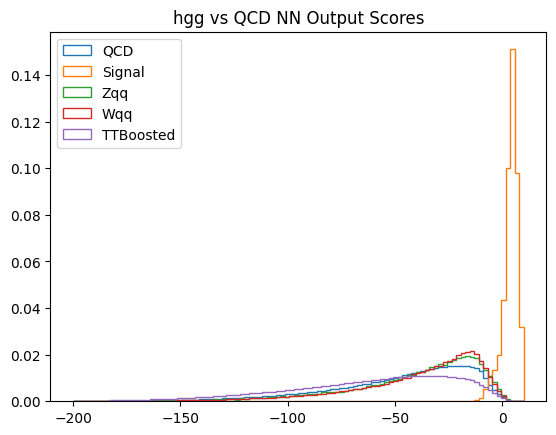

In [29]:
plt.hist(bkg_score, bins=100, range=(-200, 10), label='QCD', density=True, histtype='step')
plt.hist(sig_score, bins=100, range=(-200, 10), label='Signal', density=True, histtype='step')
plt.hist(zqq_score, bins=100, range=(-200, 10), label='Zqq', density=True, histtype='step')
plt.hist(wqq_score, bins=100, range=(-200, 10), label='Wqq', density=True, histtype='step')
plt.hist(ttboosted_score, bins=100, range=(-200, 10), label='TTBoosted', density=True, histtype='step')
# plt.hist(singletop_score, bins=100, range=(-200, 10),  label='Singletop', density=True, histtype='step')
# plt.hist(zz_score, bins=100, range=(-200, 10), label='ZZ', density=True, histtype='step')
# plt.hist(wz_score, bins=100, range=(-200, 10), label='WZ', density=True, histtype='step')
# plt.hist(ww_score, bins=100, range=(-200, 10), label='WW', density=True, histtype='step')
plt.title(f'{title} vs QCD NN Output Scores')
plt.legend()
plt.show()

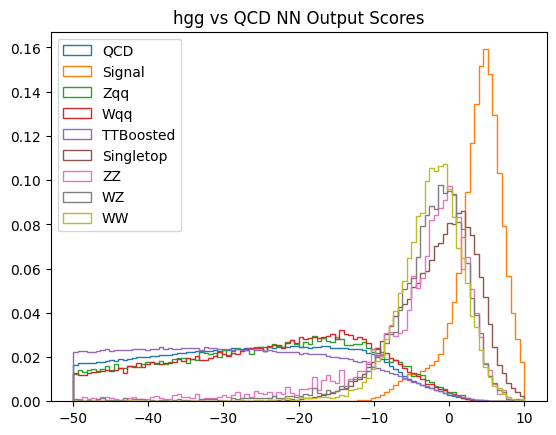

In [25]:
plt.hist(bkg_score, bins=100, range=(-50, 10), label='QCD', density=True, histtype='step')
plt.hist(sig_score, bins=100, range=(-50, 10), label='Signal', density=True, histtype='step')
plt.hist(zqq_score, bins=100, range=(-50, 10), label='Zqq', density=True, histtype='step')
plt.hist(wqq_score, bins=100, range=(-50, 10), label='Wqq', density=True, histtype='step')
plt.hist(ttboosted_score, bins=100, range=(-50, 10), label='TTBoosted', density=True, histtype='step')
plt.hist(singletop_score, bins=100, range=(-50, 10),  label='Singletop', density=True, histtype='step')
plt.hist(zz_score, bins=100, range=(-50, 10), label='ZZ', density=True, histtype='step')
plt.hist(wz_score, bins=100, range=(-50, 10), label='WZ', density=True, histtype='step')
plt.hist(ww_score, bins=100, range=(-50, 10), label='WW', density=True, histtype='step')
plt.title(f'{title} vs QCD NN Output Scores')
plt.legend()
plt.show()

In [26]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea2024/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: overflow encountered in exp
  return impl(*broadcasted_args, **(kwargs or {}))


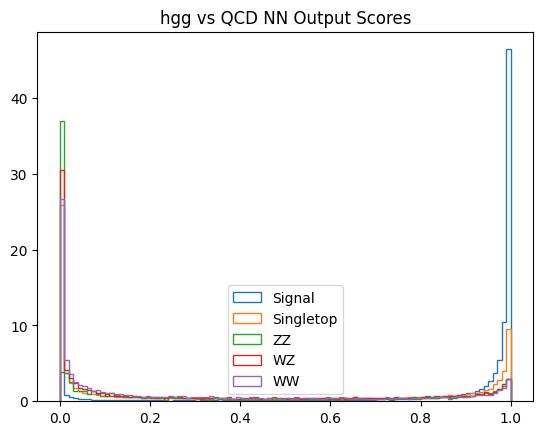

In [27]:
# plt.hist(sigmoid(bkg_score), bins=100, range=(0, 1), label='QCD', density=True, histtype='step')
plt.hist(sigmoid(sig_score), bins=100, range=(0, 1), label='Signal', density=True, histtype='step')
# plt.hist(sigmoid(zqq_score), bins=100, range=(0, 1), label='Zqq', density=True, histtype='step')
# plt.hist(sigmoid(wqq_score), bins=100, range=(0, 1), label='Wqq', density=True, histtype='step')
# plt.hist(sigmoid(ttboosted_score), bins=100, range=(0, 1), label='TTBoosted', density=True, histtype='step')
plt.hist(sigmoid(singletop_score), bins=100, range=(0, 1),  label='Singletop', density=True, histtype='step')
plt.hist(sigmoid(zz_score), bins=100, range=(0, 1), label='ZZ', density=True, histtype='step')
plt.hist(sigmoid(wz_score), bins=100, range=(0, 1), label='WZ', density=True, histtype='step')
plt.hist(sigmoid(ww_score), bins=100, range=(0, 1), label='WW', density=True, histtype='step')
plt.title(f'{title} vs QCD NN Output Scores')
plt.legend()
plt.show()

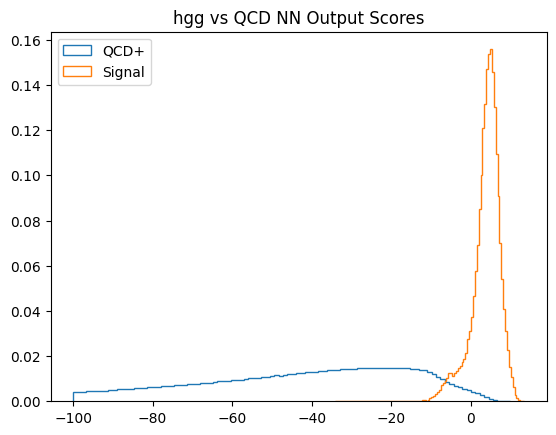

In [28]:
plt.hist(full_bkg_score, bins=100, label='QCD+', range=(-100,10), density=True, histtype='step')
plt.hist(sig_score, bins=100, label='Signal', density=True, histtype='step')
plt.title(f'{title} vs QCD NN Output Scores')
plt.legend()
plt.show()